In [1]:
# Import the required modules
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# N06 Monthly Means Dataset

## Description

The model used in experiments here is the Nucleus for European Modelling of the Ocean (NEMO), coupled to the Louvain-la-Neuve Ice Model (LIM2) sea ice model (Fichefet & Maqueda, 1997; Goosse & Fichefet, 1999; Madec, 2014). This version of NEMO has 75 depth levels (31 of which are in the top 200 m, with resolution as fine as 1 m in the uppermost layer), and has a horizontal resolution of approximately 1/12°, giving it a grid length-scale of 3-5 km in the Arctic, making it eddy permitting throughout the Arctic, though not fully eddy resolving on the shelves (Nurser & Bacon, 2014). NEMO is forced at the air-sea interface using the version 5.2 DRAKKAR forcing set (Brodeau et al., 2010). This includes 6-hourly winds, temperature and humidity from ERA40 reanalysis, daily longwave and shortwave radiative fluxes, and monthly means for precipitation and river runoff from CORE2 reanalysis. The DRAKKAR forcing set utilizes a monthly climatology for riverine input (Brodeau et al., 2010; Timmermann et al., 2005), with freshwater added at the surface level in this configuration of NEMO. The model was run with this DRAKKAR forcing set forcing between 1958 and 2015.

## References

1. https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019JC015022
1. https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016JC011660

In [2]:
# Open the N06 dataset
ds = xr.open_zarr("https://noc-msm-o.s3-ext.jc.rl.ac.uk/n06-dataset/n06.zarr")
ds

<xarray.Dataset>
Dimensions:       (deptht: 75, time_counter: 696, y: 3059, x: 4322)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) datetime64[ns] 1958-01-16T12:00:00 ... 2015-...
Dimensions without coordinates: y, x
Data variables: (12/19)
    e3t           (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 5, 577, 577), meta=np.ndarray>
    mldkz5        (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    mldr10_1      (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(577, 577), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(577, 577), meta=np.ndarray>
    potemp        (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 5, 577, 577), meta=np.ndarray>
    ...            ...
    sst           (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    taum          (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    tohfls        (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    tossq         (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    wfo           (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
    zossq         (time_counter, y, x) float32 dask.array<chunksize=(1, 577, 577), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:  80
    DOMAIN_size_global:   [4322, 3059]
    conventions:          CF-1.1
    description:          ocean T grid variables
    ibegin:               1
    jbegin:               1
    name:                 ORCA0083-N06_1m_19580101_19581231
    ni:                   4322
    nj:                   39
    production:           An IPSL model
    timeStamp:            2014-Nov-25 21:17:06 GMT

Using the interactive dataset description outputted by `xarray`, we can determine the shape of the chunks in this dataset. Specifically, for this version of the N06 dataset with dimensions (time_counter, depth, y, x) -> (3059, 75, 3059, 4322), the data is chunked into smaller blocks of shape (1, 5, 577, 577). This chunking scheme aims to strike a balance between operations, typically time averages, that require access to the entire xy plane at a given depth value and operations that require access to the entire depth profile at a given grid point. Alternatively, you can determine the chunking scheme by using the following block of code:

In [3]:
for var, chunks in ds.chunksizes.items():
    print(var, chunks[0])

time_counter 1
deptht 5
y 577
x 577


## Creating domain weights

In [4]:
# Create weights
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area
weights = np.cos(np.deg2rad(ds.nav_lat.load()))
weights.name = "weights"
weights = weights.fillna(0)

In [5]:
# Select the desired time slice
ds_slice = ds.sel(time_counter=slice("2015-02-01", "2015-12-31"))
ds_slice.time_counter

<xarray.DataArray 'time_counter' (time_counter: 11)>
array(['2015-02-12T11:58:56.000000000', '2015-03-14T11:58:56.000000000',
       '2015-04-16T00:00:00.000000000', '2015-05-16T00:00:00.000000000',
       '2015-06-15T00:00:00.000000000', '2015-07-15T00:00:00.000000000',
       '2015-08-14T00:00:00.000000000', '2015-09-13T00:00:00.000000000',
       '2015-10-13T00:00:00.000000000', '2015-11-12T00:00:00.000000000',
       '2015-12-14T12:01:04.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2015-02-12T11:58:56 ... 2015-...
Attributes:
    axis:           T
    long_name:      Time axis
    standard_name:  time
    time_origin:    1950-01-01 00:00:00
    title:          Time

## Plot global means time series

CPU times: user 10.5 s, sys: 2.47 s, total: 13 s
Wall time: 1min 2s


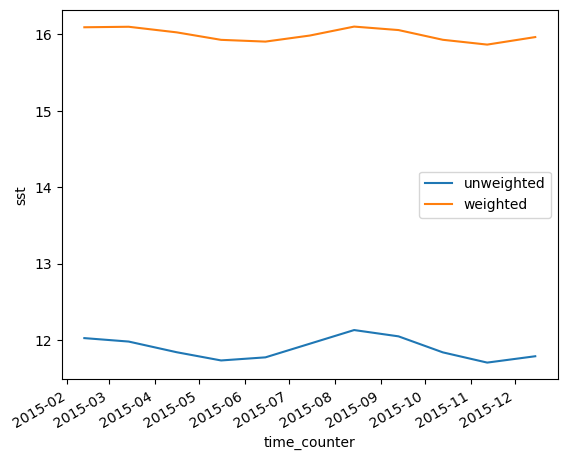

In [6]:
%%time
# Sea surface temperature
ds_slice.sst.mean(dim=["x", "y"]).plot(label="unweighted")
ds_slice.sst.weighted(weights).mean(dim=["x", "y"]).plot(label="weighted")
plt.legend()

CPU times: user 8.98 s, sys: 1.7 s, total: 10.7 s
Wall time: 50.6 s


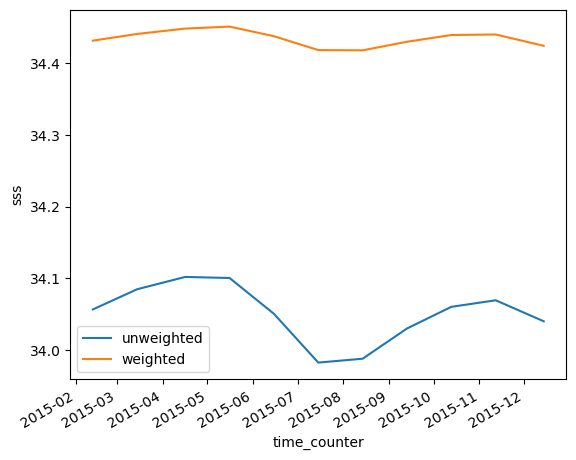

In [7]:
%%time
# Sea Surface Salinity
ds_slice.sss.mean(dim=["x", "y"]).plot(label="unweighted")
ds_slice.sss.weighted(weights).mean(dim=["x", "y"]).plot(label="weighted")
plt.legend()

## Dask Cluster

Since the N06 monthly means dataset is stored in the Zarr format, its chunks can be retrieved in parallel using libraries such as Dask. This often improves the performance of both downloading the required chunks and performing the desired calculations. In the following steps, we create a Dask `LocalCluster` to enable parallel access and processing of this dataset, which is stored in the JASMIN Object store.

In [8]:
# Import the necessary classes
from dask.distributed import Client, LocalCluster

In [10]:
# Create the Dask client and LocalCluster
# Please note that, depending on the system where you are running this, parallel processing may be slower due to overhead costs.# Here, we set up a LocalCluster with 4 workers, having 2 threads, running as separate processes
cluster = LocalCluster(n_workers=4, threads_per_worker=2, processes=True)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37849,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.58 GiB
Comm: tcp://127.0.0.1:37613,Total threads: 2
Dashboard: http://127.0.0.1:39079/status,Memory: 7.65 GiB
Nanny: tcp://127.0.0.1:40559,


In [ ]:
%%time
# Sea surface temperature
ds_slice.sst.mean(dim=["x", "y"]).plot(label="unweighted")
ds_slice.sst.weighted(weights).mean(dim=["x", "y"]).compute().plot(label="weighted")
plt.legend()

Note that the wall time required to run the previous cell is lower than that required to run the equivalent cell above where no Dask cluster was set up.

In [ ]:
# Plot the annual mean on the global domain
ds_slice.sst.weighted(weights).mean(dim=["time_counter"]).plot()

## Other Dask Clusters

If you are running this notebook on the login node of an HPC cluster, such as the one available on JASMIN, you can easily spin up a `SLURMCluster` or a `PBSCluster` by following the instructions available [here](https://jobqueue.dask.org/en/latest/examples.html). Apart from requiring the importation of the chosen cluster object (e.g., `from dask_jobqueue import SLURMCluster`), the rest of the operations should mimic the ones shown above when spinning up a `SLURMCluster` on JASMIN.

If you are using the JASMIN Notebooks Service, you must use the JASMIN Dask Gateway to use Dask in Lotus, as explained in [this repository](https://github.com/cedadev/jasmin-daskgateway). An example that uses `xarray` can be found [here](https://github.com/cedadev/jasmin-daskgateway/blob/main/examples/xarray.ipynb).

Note that on login nodes, you can, in principle, create a `LocalCluster`, but please be conscious of whether it uses too many resources needed by other users.